# Predicting Disney Stock Price Using Time Series Data Code Document

# David Berberena

# 10/20/2024

### Library and Dataset Importation

In [1]:
# I will import the necessary libraries needed for data mining, exploratory data analysis, and data preparation here.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
from pmdarima import auto_arima
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import warnings

warnings.filterwarnings('ignore')

In [2]:
# I will read in the dataset and display it using the head() function.

disney_stock_data = 'https://raw.githubusercontent.com/SosukeAizen5/Portfolio/refs/heads/main/DSC%20680%20Applied%20Data%20Science/DIS.csv'

disney = pd.read_csv(disney_stock_data)

disney.head()

,Date,Open,High,Low,Close,Volume
0,1962-01-02,0.057941,0.059886,0.057941,0.057941,841958
1,1962-01-03,0.057941,0.058914,0.057941,0.058719,801865
2,1962-01-04,0.058719,0.058914,0.058331,0.058719,962238
3,1962-01-05,0.058719,0.059108,0.058525,0.058914,962238
4,1962-01-08,0.058914,0.059691,0.057553,0.058719,1282984


### Data Preparation

In [3]:
# I will now check the data types of each column's observations within the dataset. I can do this using .dtypes.

disney.dtypes

Date       object
Open      float64
High      float64
Low       float64
Close     float64
Volume      int64
dtype: object

In [4]:
# Since we are dealing with time series data, I must convert the Date column into a format recognized by Python as time 
# series data, which is why I will use pd.to_datetime(). I also am choosing to convert the Volume column to the float type
# to keep the data types the same (it is not necessary yet it is my preference to do so) using .astype().

disney['Date'] = pd.to_datetime(disney['Date'])
disney['Volume'] = disney['Volume'].astype(float)

disney.dtypes

Date      datetime64[ns]
Open             float64
High             float64
Low              float64
Close            float64
Volume           float64
dtype: object

In [5]:
# The dataset is now ready for the exploratory data analysis stage. I will print the dataset to show the current changes.

disney.head()

,Date,Open,High,Low,Close,Volume
0,1962-01-02,0.057941,0.059886,0.057941,0.057941,841958.0
1,1962-01-03,0.057941,0.058914,0.057941,0.058719,801865.0
2,1962-01-04,0.058719,0.058914,0.058331,0.058719,962238.0
3,1962-01-05,0.058719,0.059108,0.058525,0.058914,962238.0
4,1962-01-08,0.058914,0.059691,0.057553,0.058719,1282984.0


### Initial Exploratory Data Analysis

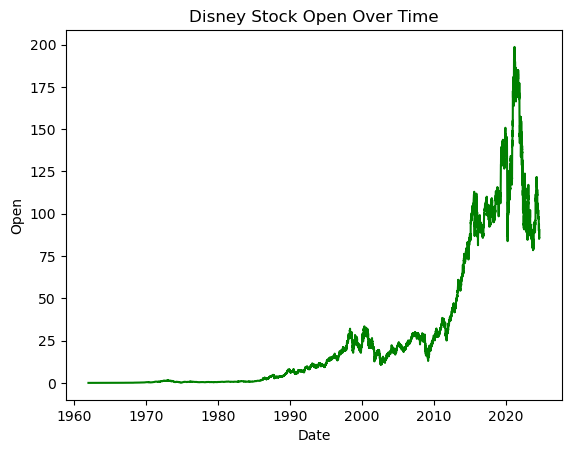

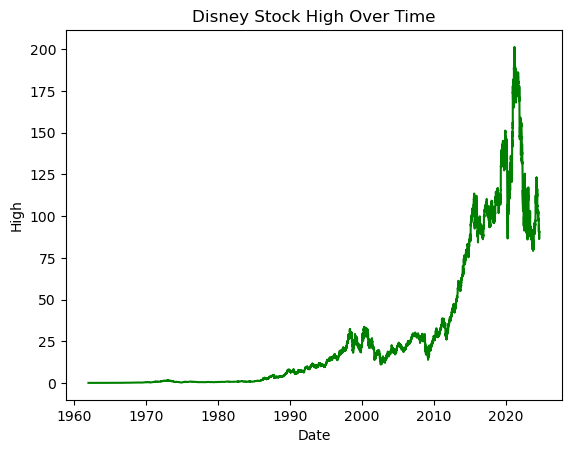

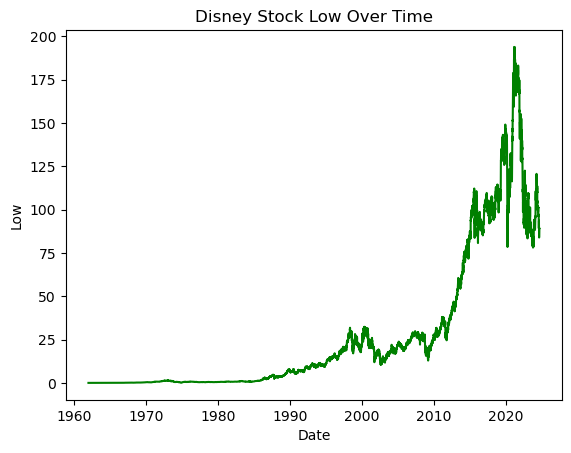

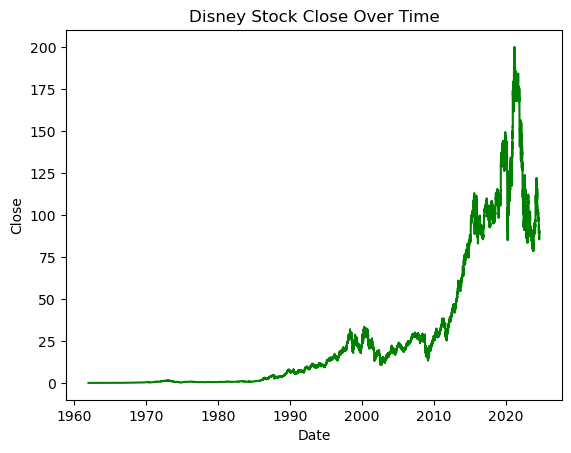

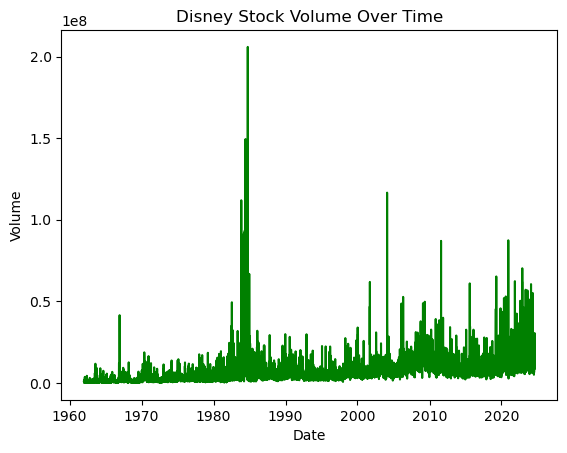

In [6]:
# I'd like to visualize multiple line charts highlighting the stock price trends over time for each variable. I will craft a
# for loop that will access a function created to output a line chart for each variable in the dataset. The function will 
# take a DataFrame and a column as arguments.

def make_line_charts(data, col):
    plt.plot(data['Date'], data[col], color = 'green')
    plt.title(f'Disney Stock {col} Over Time')
    plt.xlabel('Date')
    plt.ylabel(f'{col}')
    plt.show()
    
for col in disney.drop(['Date'], axis = 1).columns:
    make_line_charts(disney, col)

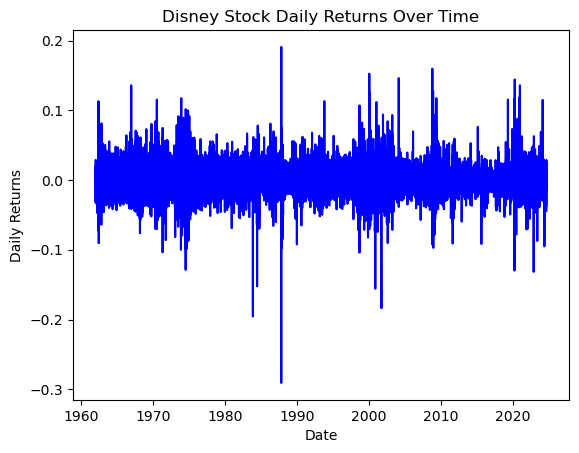

In [7]:
# Next, I wish to visualize the daily stock price returns, which can be calculated by taking the percent change of the 
# closing stock price from the previous trading day. Laying these daily returns out over time can shed light on how volatile
# Disney stock has been throughout the years.

disney['Daily Return'] = disney['Close'].pct_change()

plt.plot(disney['Date'], disney['Daily Return'], color = 'blue')
plt.title('Disney Stock Daily Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Daily Returns')

plt.show()

In [8]:
# Now that the daily returns chart shows an image of how volatile Disney stock has been over time, I'd like to quantify this
# volatility even further by setting volatility equal to the 10-day (two-week trading period) rolling standard deviation of
# daily returns. By adding this feature into the dataset, we can see the level of volatility over a 10-day period as a 
# number rather than an image left for interpretation.

disney['Volatility'] = disney['Daily Return'].rolling(window = 10).std()

# Since we have added the Daily Return and Volatility columns, we need to account for missing values we have unintentionally
# created. It is expected that the Daily Returns column should have one missing value, and that is the percent change value
# of the first observation, as there would be no percentage change from the first observation. For the Volatility variable,
# the first ten observations are expected to be missing since no 10-day rolling standard deviation can be established prior
# to ten past observations. I will fix this by inputting zeros for these missing values using fillna().

disney.fillna(0, inplace = True)

# I will print the dataset to show the missing values filled in as well as the Daily Returns and Volatility columns.

disney.head(30)

,Date,Open,High,Low,Close,Volume,Daily Return,Volatility
0,1962-01-02,0.057941,0.059886,0.057941,0.057941,841958.0,0.000000,0.000000
1,1962-01-03,0.057941,0.058914,0.057941,0.058719,801865.0,0.013422,0.000000
2,1962-01-04,0.058719,0.058914,0.058331,0.058719,962238.0,0.000000,0.000000
3,1962-01-05,0.058719,0.059108,0.058525,0.058914,962238.0,0.003314,0.000000
4,1962-01-08,0.058914,0.059691,0.057553,0.058719,1282984.0,-0.003303,0.000000
5,1962-01-09,0.058719,0.059886,0.058331,0.059886,641492.0,0.019872,0.000000
6,1962-01-10,0.059886,0.060858,0.059886,0.060469,681585.0,0.009737,0.000000
7,1962-01-11,0.060469,0.062608,0.060275,0.062219,2004663.0,0.028939,0.000000
8,1962-01-12,0.062219,0.062414,0.059497,0.060275,2004663.0,-0.031243,0.000000
9,1962-01-15,0.060275,0.060664,0.059886,0.060275,641492.0,0.000000,0.000000


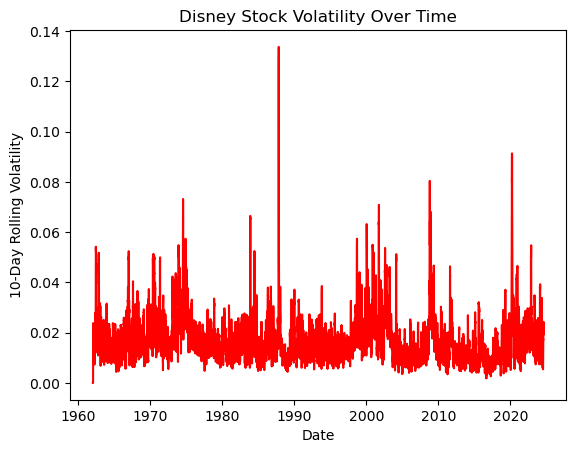

In [9]:
# Now that volatility has been defined, I will plot this variable over time as well with a line chart.

plt.plot(disney['Date'], disney['Volatility'], color = 'red')
plt.title('Disney Stock Volatility Over Time')
plt.xlabel('Date')
plt.ylabel('10-Day Rolling Volatility')

plt.show()

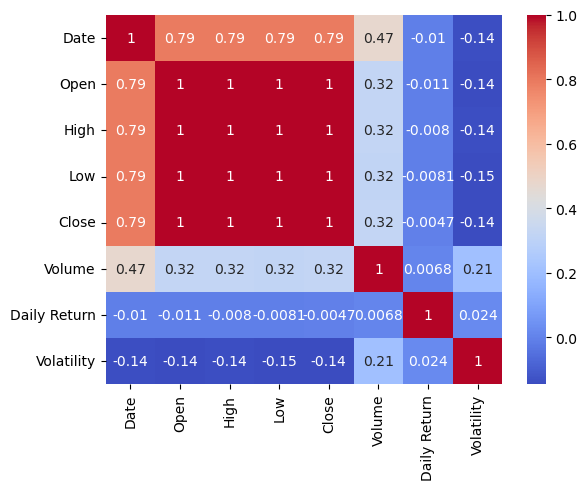

In [10]:
# Next, I will craft a heatmap that visualizes the correlation between my outcome variable of closing stock price (Close)
# and the other variables within the dataset. This can be accomplished using Seaborn's heatmap() function.

sns.heatmap(disney.corr(), annot = True, cmap = 'coolwarm')
plt.show()

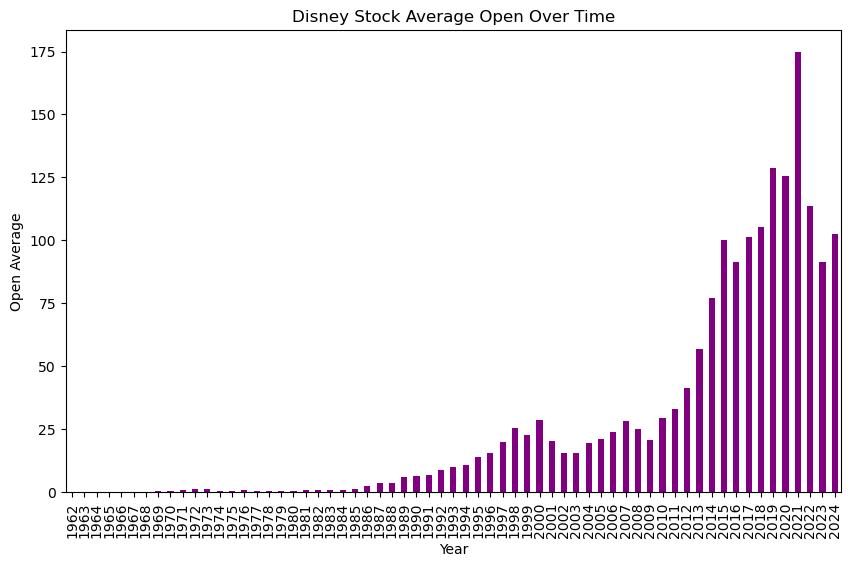

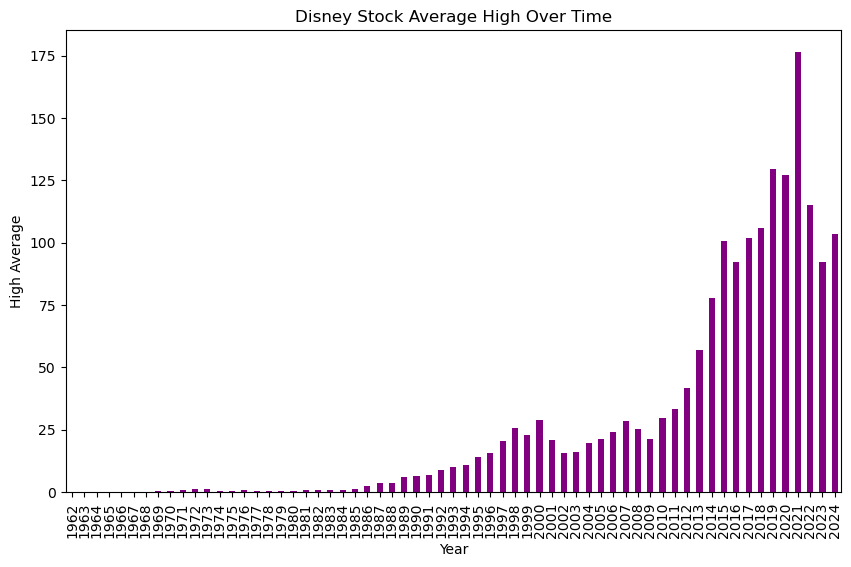

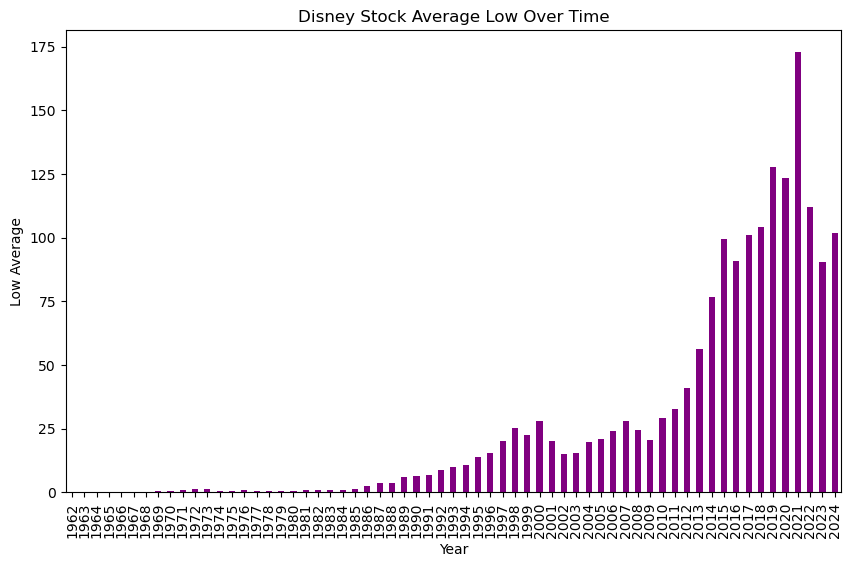

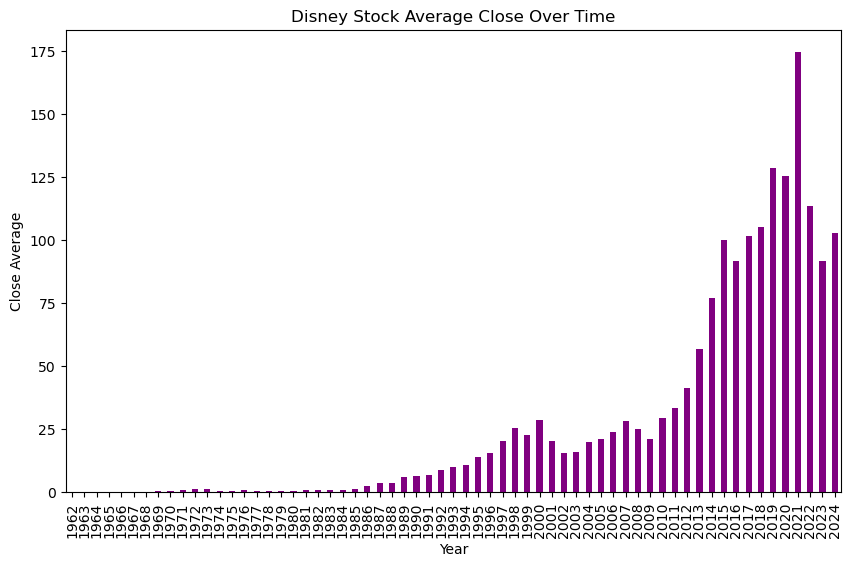

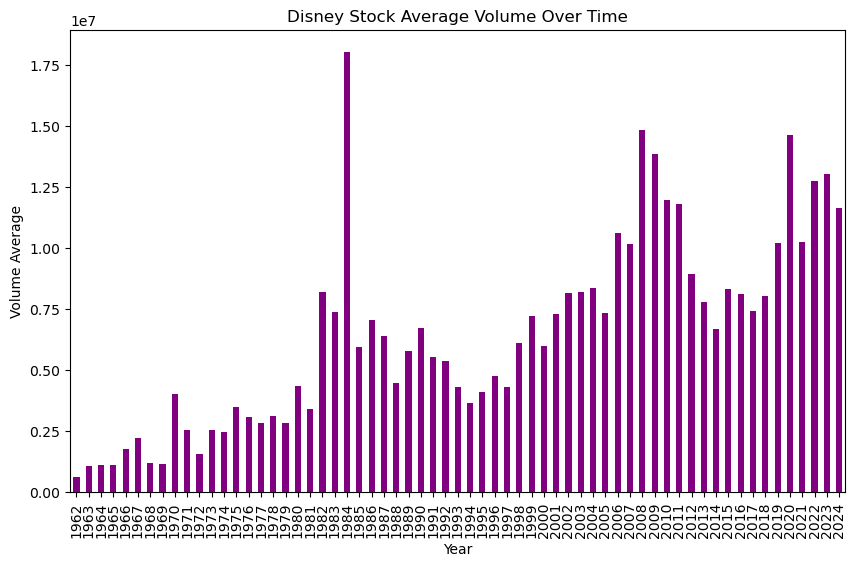

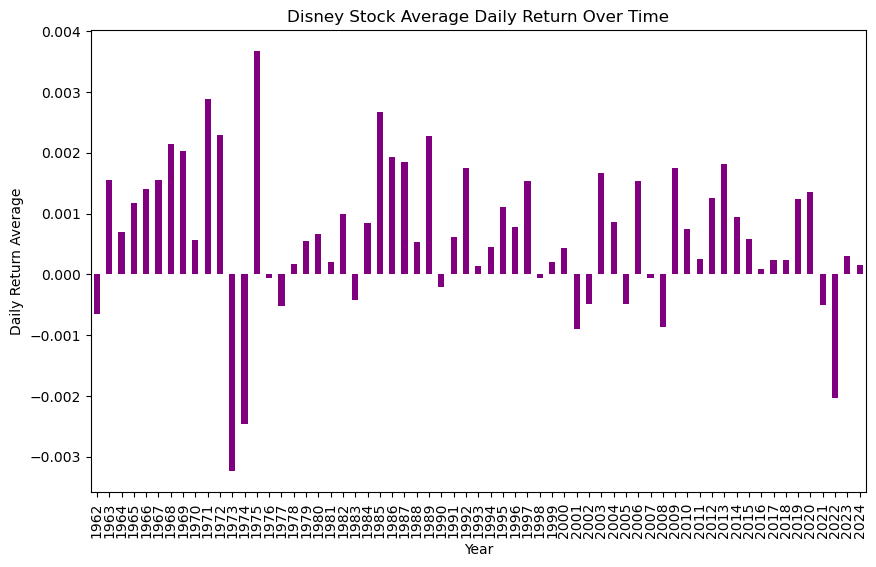

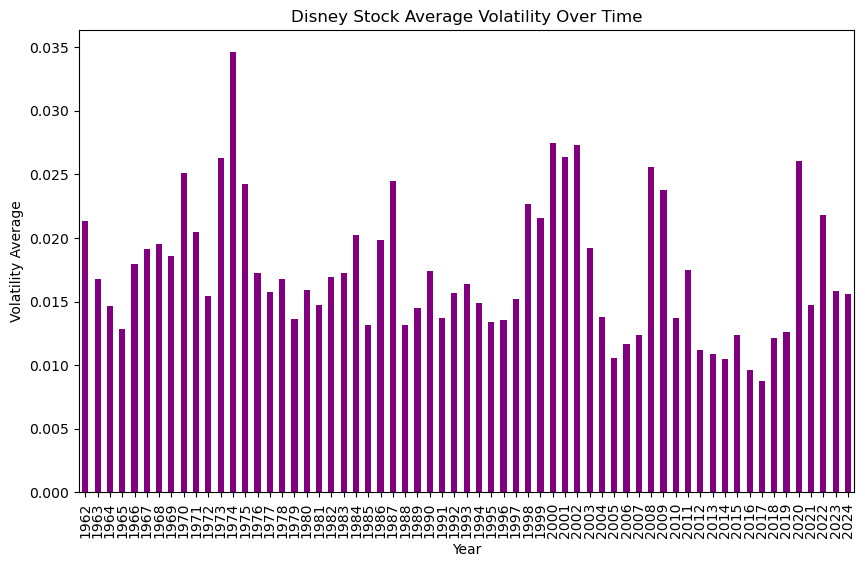

In [11]:
# To finalize my EDA, I will plot the variables within the dataset based on their yearly averages after grouping the data by
# the year and the specified column. This will be done by employing bar charts and another for loop that iterates through 
# each variable. Visualizing these charts will allow us to see the stock prices over the years and view which years had the 
# highest and lowest variable averages. 

disney['Year'] = disney['Date'].dt.year

for col in disney.drop(['Date', 'Year'], axis = 1).columns:
    yearly_avg = disney.groupby('Year')[col].mean()
    plt.figure(figsize = (10,6))
    yearly_avg.plot(kind = 'bar', color = 'purple')
    plt.title(f'Disney Stock Average {col} Over Time')
    plt.xlabel('Year')
    plt.ylabel(f'{col} Average')
    plt.show()

### Training and Test Set Split and Model Creation

In [12]:
# Before I craft my initial model choice, that being the ARIMA model, I need to perform the Augmented Dickey-Fuller (ADF) 
# test on the Close outcome variable. This will test whether the data is stationary and whether the data requires 
# differencing to become stationary. To do this, I will first set the index of the dataset to be the dates, then I will 
# extract the Close variable to perform the ADF test. The ADF test will be conducted using the adfuller() function.
# After looking at the trends uncovered during the EDA phase, I have decided to subset the data to only include the most 
# recent ten years (starting from the beginning of 2015) of stock price data. As Disney's stock price has increased 
# drastically from its initial public offering (IPO) price, the ARIMA model will not handle the outlier data points that 
# belong to the first few decades listed in the dataset. 

disney.set_index('Date', inplace = True)

close_prices = disney['Close']

disney_2015_close = close_prices[close_prices.index >= '2015-01-01']

result = adfuller(disney_2015_close)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

if result[1] > 0.05:
    print("The series is not stationary and differencing is required.")
else:
    print("The series is stationary.")

ADF Statistic: -1.960204
p-value: 0.304290
The series is not stationary and differencing is required.


In [13]:
# Now that I know the data needs to be differenced, I can address that when crafting the model and proceed with splitting 
# the remaining data into training and test sets. As the data we are dealing with is time series data, the typical 
# train_test_split() function doesn't support this kind of data. So I will manually split the data into their respective 
# sets by indexing to achieve the 80/20 data split that is typical of data science projects.

close_split = int(len(disney_2015_close) * 0.8)
close_train, close_test = disney_2015_close.iloc[:close_split], disney_2015_close.iloc[close_split:]

# To verify that the split has been successful in its ratio of observations, I will print the shapes of each set.

print('The size of the dataset prior to being split is:', disney_2015_close.shape[0])
print('The size of the training dataset after being split is:', close_train.shape[0])
print('The size of the test dataset after being split is:', close_test.shape[0])

The size of the dataset prior to being split is: 2424
The size of the training dataset after being split is: 1939
The size of the test dataset after being split is: 485


In [14]:
# After seeing that the data needs to be differenced to become stationary, I can use the auto_arima() to help determine the
# number of times the data needs to be differenced to achieve stationarity. The helpful thing about the auto_arima() 
# function is that it has a built-in grid search that optimizes the other parameters to output the best performing ARIMA 
# model. So in addition to finding the best value for d, the differencing factor, this function also finds the best lag 
# order (p) value and the best moving average order (q) value.

disney_close_model = auto_arima(close_train, seasonal = True, m = 5, trace = True, 
                                suppress_warnings = True, stepwise = True, information_criterion = 'aic', n_jobs = -1)

print(disney_close_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[5] intercept   : AIC=8376.553, Time=3.21 sec
 ARIMA(0,1,0)(0,0,0)[5] intercept   : AIC=8376.994, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[5] intercept   : AIC=8374.051, Time=0.33 sec
 ARIMA(0,1,1)(0,0,1)[5] intercept   : AIC=8374.255, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[5]             : AIC=8375.067, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[5] intercept   : AIC=8372.057, Time=0.21 sec
 ARIMA(1,1,0)(0,0,1)[5] intercept   : AIC=8374.052, Time=0.34 sec
 ARIMA(1,1,0)(1,0,1)[5] intercept   : AIC=8371.224, Time=1.53 sec
 ARIMA(1,1,0)(2,0,1)[5] intercept   : AIC=8370.567, Time=0.97 sec
 ARIMA(1,1,0)(2,0,0)[5] intercept   : AIC=8371.330, Time=0.43 sec
 ARIMA(1,1,0)(2,0,2)[5] intercept   : AIC=8369.101, Time=2.03 sec
 ARIMA(1,1,0)(1,0,2)[5] intercept   : AIC=8370.006, Time=1.10 sec
 ARIMA(0,1,0)(2,0,2)[5] intercept   : AIC=8375.573, Time=1.89 sec
 ARIMA(2,1,0)(2,0,2)[5] intercept   : AIC=8370.847, Time=2.48 sec
 ARIMA(1,1,1)(2,0,2)[5] intercept

In [15]:
# Now that we have our model, which turned out to be a SARIMAX model instead of my chosen ARIMA model due to the presence of
# seasonality within the data (as shown in some of the charts displayed in the EDA stage), we can craft our predictions to 
# realize the Root Mean Squared Error (RMSE) statistic, which will identify the margin of error between the predicted values
# and the actual data points. I also will output the R-Squared (coefficient of determination) to see how much variance 
# within the data is explained by the model.

predictions = disney_close_model.predict(n_periods = len(close_test))

disney_close_rmse = np.sqrt(mean_squared_error(close_test, predictions))
disney_close_r2 = r2_score(close_test, predictions)

print('The RMSE of the SARIMAX model is', disney_close_rmse)
print('The R-Squared value of the SARIMAX model is', disney_close_r2)

The RMSE of the SARIMAX model is 18.241334161337864
The R-Squared value of the SARIMAX model is -2.663274327041615


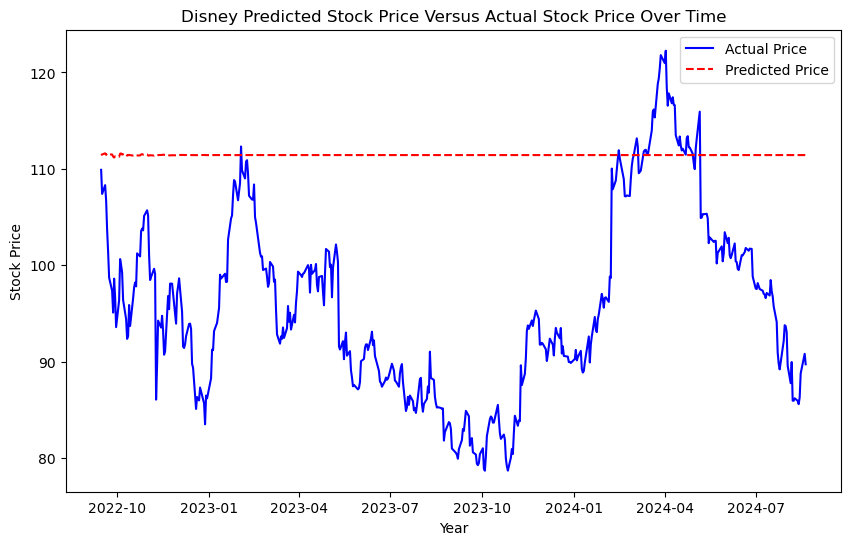

In [16]:
# Now while the RMSE shows the overall margin of error between the model's predictions and the actual values, I would like 
# to see the predictions plotted over time against the test values. Upon creating a line chart showcasing both sets of 
# values, we can visually see whether the predictions mirror the test value closely.

plt.figure(figsize = (10,6))
plt.plot(close_test.index, close_test.values, label = 'Actual Price', color = 'blue')
plt.plot(close_test.index, predictions.values, label = 'Predicted Price', color = 'red', linestyle='--')

plt.title('Disney Predicted Stock Price Versus Actual Stock Price Over Time')
plt.xlabel('Year')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

With both the RMSE statistic and the prediction line chart highlighting an underwhelming performance from the SARIMAX model, I will be moving forward with the creation of a random forest regressor model. I believe that the random forest regressor may be able to take more variables under consideration than the SARIMAX model as the entirety of the dataset can be used to train the 
model as opposed to only the outcome Close variable. Should the random forest regressor perform poorly as well, I will revisit
the auto_arima() function to output a SARIMAX model that will be able to handle the other external variables as well. 

In [17]:
# To create the random forest regressor, I will need to resplit the data using the same ratio, yet I will use 
# train_test_split() to do so. To do this though, as the random forest algorithm isn't equipped to handle time series data 
# naturally, I will be adding lagged values to the dataset so the algorithm can learn that the past observations affect the
# future values. I will input five lagged value variables (one trading week's worth of stock prices) based on the Close
# variable and then I will drop the rows containing missing values. 

for i in range(1, 6):
    disney[f'Lag {i}'] = disney['Close'].shift(i)
    
# To provide the random forest regressor with more features that could potentiall increase the algorithm's accuracy in 
# predicting future Disney stock price, I will add even more features to the dataset, specifically moving averages 
# (3, 5, and 10-day) for both the Close variable and the Volume variables.

disney['Three Day Close Rolling Mean'] = disney['Close'].rolling(window = 3).mean()
disney['Five Day Close Rolling Mean'] = disney['Close'].rolling(window = 5).mean()
disney['Ten Day Close Rolling Mean'] = disney['Close'].rolling(window = 10).mean()

disney['Three Day Volume Rolling Mean'] = disney['Volume'].rolling(window = 3).mean()
disney['Five Day Volume Rolling Mean'] = disney['Volume'].rolling(window = 5).mean()
disney['Ten Day Volume Rolling Mean'] = disney['Volume'].rolling(window = 10).mean()

disney.dropna(inplace = True)

disney_x = disney.drop('Close', axis = 1)
disney_2015_x = disney_x[disney_x.index >= '2015-01-01']
disney_y = disney['Close']
disney_2015_y = disney_y[disney_y.index >= '2015-01-01']

# For time series data, the order in which the observations take place is important, so I will set the shuffle argument to 
# False so I can split the data so as to keep the most recent observations within the test set and the oldest observations
# in the training set.

close_xtrain, close_xtest, close_ytrain, close_ytest = train_test_split(disney_2015_x, disney_2015_y, test_size = 0.2, 
                                                                        shuffle = False)

random_forest_close_model = RandomForestRegressor(n_estimators = 100, random_state = 123)
random_forest_close_model.fit(close_xtrain, close_ytrain)

RandomForestRegressor(random_state=123)

In [18]:
# Now that the model has been crafted, I will output its performance metrics (RMSE and R-Squared).

rf_predictions = random_forest_close_model.predict(close_xtest)

rf_close_rmse = np.sqrt(mean_squared_error(close_ytest, rf_predictions))
rf_close_r2 = r2_score(close_ytest, rf_predictions)

print('The RMSE of the random forest regressor model is', rf_close_rmse)
print('The R-Squared value of the random forest regressor model is', rf_close_r2)

The RMSE of the random forest regressor model is 1.2401795293864457
The R-Squared value of the random forest regressor model is 0.9830673332570158


Upon seeing the performance metrics for the random forest algorithm, it can be seen that not only does the model perform better than the SARIMAX model's output based on the RMSE, but the fact that the R-Squared is over 0.98 indicates that the model is a good fit for the data as over 98% of the variance within the data can be explained by the model. I will output a visualization showcasing predicted versus actual values for this model as well to make sure that the random forest regressor does indeed closely mirror the true stock prices over time. 

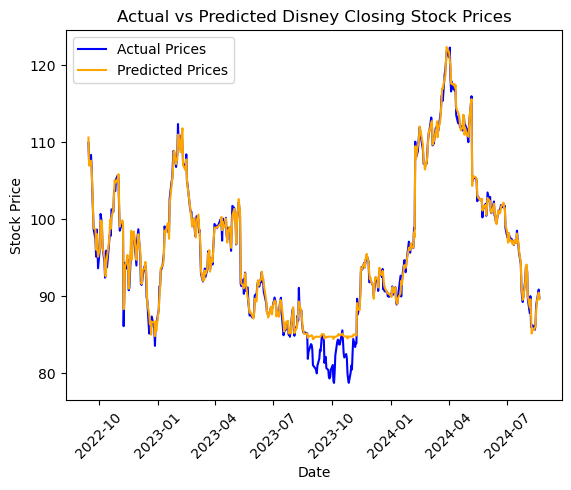

In [19]:
# The line plot that will confirm whether the predictions closely resemble Disney's actual stock prices is created here.

plt.plot(close_ytest.index, close_ytest, label = 'Actual Prices', color = 'blue')
plt.plot(close_ytest.index, rf_predictions, label = 'Predicted Prices', color = 'orange')
plt.title('Actual vs Predicted Disney Closing Stock Prices')
plt.xlabel('Date')
plt.xticks(rotation = 45)
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [20]:
# The last thing I wish to view with this random forest regressor before moving forward with next steps is the features that
# are considered important in predicting Disney's closing stock price. I can access the model's feature importances and 
# order them to see the most important features first. 

importances = random_forest_close_model.feature_importances_
feature_names = close_xtrain.columns

sorted_indices = np.argsort(importances)[::-1]
print("\nRandom Forest Regressor Feature importances:\n")
for idx in sorted_indices[:5]:
    print(f"     {feature_names[idx]}: {importances[idx]:.4f}")



Random Forest Regressor Feature importances:

     High: 0.5087
     Low: 0.4163
     Three Day Close Rolling Mean: 0.0395
     Open: 0.0239
     Lag 1: 0.0095


In [21]:
# With the confirmation that the random forest regressor model has done well in predicting Disney stock price, I'd like to
# go a step further and have the model output predictions for observations beyond the dataset's observations, which would 
# mean that the model needs to predict Disney's stock price past August 20, 2024. To accomplish this, I need to create a 
# DataFrame that houses data similar to the dataset we have already at our disposal. I will create a date range variable 
# that starts on August 21, 2024 and ends 25 business days from that date (September 2nd cannot be included due to Labor Day
# being an observed federal holiday with the stock market closed).  

future_dates = pd.date_range(start = '2024-08-21', periods = 26, freq = 'B').difference([pd.Timestamp('2024-09-02')])

# I will create the DataFrame that will hold these dates and will have the other features seen in our previous dataset added
# in to mimic real data observations.

future_data = pd.DataFrame(index = future_dates)

# To add the variables seen in the Kaggle dataset along with the features I have engineered, I will extract the last data 
# point from every feature, add a random small change with the help of np.random.normal() and make that new feature column 
# the same size as the future dates series that was created earlier. The only feature that will not have the slight 
# numerical variation is the Year column since it is meant to be a string value. The small numerical change has been added 
# to simulate real-world stock variability and to prevent the inputation of uniform observations.

future_data['Open'] = disney_2015_x['Open'].iloc[-1] * (1 + np.random.normal(0, 0.01, size = len(future_data)))
future_data['High'] = disney_2015_x['High'].iloc[-1] * (1 + np.random.normal(0, 0.01, size = len(future_data)))
future_data['Low'] = disney_2015_x['Low'].iloc[-1] * (1 + np.random.normal(0, 0.01, size = len(future_data)))
future_data['Volume'] = disney_2015_x['Volume'].iloc[-1] * (1 + np.random.normal(0, 0.01, size = len(future_data)))
future_data['Daily Return'] = disney_2015_x['Daily Return'].iloc[-1] * (1 + np.random.normal(0, 0.01, 
                                                                                             size = len(future_data)))
future_data['Volatility'] = disney_2015_x['Volatility'].iloc[-1] * (1 + np.random.normal(0, 0.01, size = len(future_data)))
future_data['Year'] = disney_2015_x['Year'].iloc[-1]

# The lagged features that need to be added into the future prices DataFrame will be derived from the disney_2015_y variable
# as the lagged features here were used to create the random forest regressor model, so they should mirror those values. The
# same minute numerical change will be added here as well. The same applies to the Close Rolling Mean variables.

future_data['Lag 1'] = disney_2015_y.shift(1).iloc[-1] * (1 + np.random.normal(0, 0.01))
future_data['Lag 2'] = disney_2015_y.shift(2).iloc[-1] * (1 + np.random.normal(0, 0.01))
future_data['Lag 3'] = disney_2015_y.shift(3).iloc[-1] * (1 + np.random.normal(0, 0.01))
future_data['Lag 4'] = disney_2015_y.shift(4).iloc[-1] * (1 + np.random.normal(0, 0.01))
future_data['Lag 5'] = disney_2015_y.shift(5).iloc[-1] * (1 + np.random.normal(0, 0.01))

future_data['Three Day Close Rolling Mean'] = disney_2015_y.rolling(3).mean().iloc[-1] * (1 + np.random.normal(0, 0.01))
future_data['Five Day Close Rolling Mean'] = disney_2015_y.rolling(5).mean().iloc[-1] * (1 + np.random.normal(0, 0.01))
future_data['Ten Day Close Rolling Mean'] = disney_2015_y.rolling(10).mean().iloc[-1] * (1 + np.random.normal(0, 0.01))

# For the Volume Rolling Mean features, I need to use the disney_2015_x variable again. 

future_data['Three Day Volume Rolling Mean'] = disney_2015_x['Volume'].rolling(3).mean().iloc[-1] * (1 + 
                                                                                                     np.random.normal(0, 
                                                                                                                      0.01))
future_data['Five Day Volume Rolling Mean'] = disney_2015_x['Volume'].rolling(5).mean().iloc[-1] * (1 + 
                                                                                                    np.random.normal(0, 
                                                                                                                     0.01))
future_data['Ten Day Volume Rolling Mean'] = disney_2015_x['Volume'].rolling(10).mean().iloc[-1] * (1 + 
                                                                                                    np.random.normal(0, 
                                                                                                                     0.01))

# With lagged values, we have unintentionally placed NaN values within the newm DataFrame, so I will address that by using
# fillna() with the method argument set to ffill to fill in the missing values with the most recent values. 

future_data.fillna(method = 'ffill', inplace = True)

# Now we can use the already crafted random forest regressor to generate closing stock price predictions on the future dates
# DataFrame. I will append these predictions to the future dates DataFrame with the purpose of plotting them against 
# Disney's actual closing stock prices to see the accuracy of the model when predicting future data points not previously 
# seen. 

future_predictions = random_forest_close_model.predict(future_data)
future_data['Predicted Close'] = future_predictions

# I will print the predictions created by the random forest regressor model to verify the transformations did yield viable 
# predictions.

print(future_data[['Predicted Close']])

            Predicted Close
2024-08-21        89.190699
2024-08-22        88.572952
2024-08-23        89.139573
2024-08-26        89.157850
2024-08-27        89.083184
2024-08-28        90.303443
2024-08-29        89.473700
2024-08-30        89.479779
2024-09-03        89.198912
2024-09-04        89.131470
2024-09-05        89.066794
2024-09-06        89.456081
2024-09-09        88.807765
2024-09-10        90.340162
2024-09-11        90.444336
2024-09-12        90.432586
2024-09-13        89.874171
2024-09-16        90.332093
2024-09-17        89.237521
2024-09-18        90.580232
2024-09-19        90.325259
2024-09-20        89.274010
2024-09-23        91.809678
2024-09-24        89.731650
2024-09-25        89.169662


In [22]:
# After looking for the actual Disney closing stock prices for the future dates in the dataset, I locked onto a Yahoo 
# Finance link that displayed them, that link being cited here: https://finance.yahoo.com/quote/DIS/history/

future_data['Actual Close'] = [90.72, 89.92, 90.56, 91.78, 90.90, 89.49, 89.81, 90.38, 89.13, 89.25, 88.65, 87.94, 88.34, 
                               88.40, 88.32, 89.30, 90.55, 91.85, 92.86, 93.58, 93.45, 93.75, 92.97, 93.69, 93.92]

# I will print the dataset to ensure the addition of the Actual Close column.

future_data.head()

,Open,High,Low,Volume,Daily Return,Volatility,Year,Lag 1,Lag 2,Lag 3,Lag 4,Lag 5,Three Day Close Rolling Mean,Five Day Close Rolling Mean,Ten Day Close Rolling Mean,Three Day Volume Rolling Mean,Five Day Volume Rolling Mean,Ten Day Volume Rolling Mean,Predicted Close,Actual Close
2024-08-21,91.661852,90.888296,88.442986,8.960365e+06,-0.011958,0.019354,2024,90.051793,90.31115,89.204752,86.999983,84.741097,90.463857,88.765443,87.026684,9.681404e+06,1.012156e+07,1.460675e+07,89.190699,90.72
2024-08-22,89.713075,88.583530,88.420638,8.840784e+06,-0.011859,0.019493,2024,90.051793,90.31115,89.204752,86.999983,84.741097,90.463857,88.765443,87.026684,9.681404e+06,1.012156e+07,1.460675e+07,88.572952,89.92
2024-08-23,90.225105,90.019347,88.298997,8.984199e+06,-0.011773,0.019429,2024,90.051793,90.31115,89.204752,86.999983,84.741097,90.463857,88.765443,87.026684,9.681404e+06,1.012156e+07,1.460675e+07,89.139573,90.56
2024-08-26,90.950918,89.836540,88.442289,8.664992e+06,-0.011948,0.019464,2024,90.051793,90.31115,89.204752,86.999983,84.741097,90.463857,88.765443,87.026684,9.681404e+06,1.012156e+07,1.460675e+07,89.157850,91.78
2024-08-27,90.810960,90.816182,87.959488,8.794890e+06,-0.011745,0.019617,2024,90.051793,90.31115,89.204752,86.999983,84.741097,90.463857,88.765443,87.026684,9.681404e+06,1.012156e+07,1.460675e+07,89.083184,90.90


In [23]:
# With the actual and predicted future closing stock prices calculated, I can calculate the new RMSE to see how small or 
# large the new margin of error is.

disney_future_close_rmse = np.sqrt(mean_squared_error(future_data['Actual Close'], future_data['Predicted Close']))

print('The RMSE of the random forest regressor model using the future Disney closing stock prices is', 
      disney_future_close_rmse)

The RMSE of the random forest regressor model using the future Disney closing stock prices is 2.2312599632468424


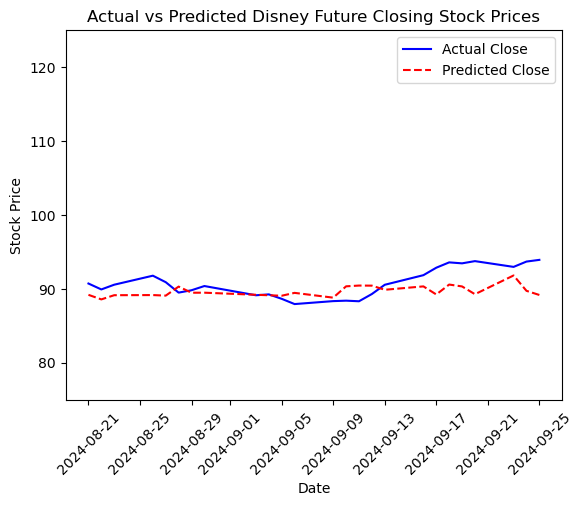

In [24]:
# I will now plot the predicted future observations against the actual future observations using the same scale as the 
# previous actual versus predictions plot to see how the model performs with unseen data. 

plt.plot(future_data.index, future_data['Actual Close'], label = 'Actual Close', color = 'blue')
plt.plot(future_data.index, future_data['Predicted Close'], label = 'Predicted Close', color = 'red', linestyle = '--')

plt.title('Actual vs Predicted Disney Future Closing Stock Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.ylim(75, 125)
plt.xticks(rotation = 45)
plt.legend()
plt.show()

After seeing the random forest regressor model's performance in lieu of the SARIMAX model's substandard results, it can be said with confidence that this model is ready for deployment for specific shareholders of the Walt Disney Company. For those who wish to hold and/or buy, shareholders can see that continuing to invest in the Company is a stable investment with little fluctuation in the next 25 business days. For those wishing to sell, these shareholders can estimate how much they stand to gain or lose if they do not want to wait and are content with the potential minimal profit/loss they may face. The model also helps to reassure shareholders of Disney's strength within its business sector, allowing a potential boost in shareholder morale and more funding for the Company to continue expanding and giving back to the community and its investors. 